In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from utils.prepare_dataset import prepare_dataset_mnist

/home/dingkang/envs/nlp_a4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_GPU = True if torch.cuda.is_available() else "cpu"

In [ ]:
max_seq_len = 64
batch_size = 64
dataset_size = 2000
with_mask = False

train_tokens, train_labels, train_mask, val_tokens, val_labels, val_mask = prepare_dataset_mnist(file="dataset/mnist_polygon_train_10k.csv",
                                                                                                 with_mask=with_mask,
                                                                                                 split_ratio=0.2,
                                                                                                 dataset_size=dataset_size,
                                                                                                 max_seq_len=max_seq_len,
                                                                                                 train=True)

test_tokens, test_labels, test_mask = prepare_dataset_mnist(file="dataset/mnist_polygon_test_2k.csv",
                                                            with_mask=with_mask,
                                                            max_seq_len=max_seq_len,
                                                            dataset_size=500,
                                                            train=False)

train_loader = DataLoader(TensorDataset(train_tokens, train_labels), batch_size=batch_size, shuffle=True)

In [12]:
class ConvAE(nn.Module):
    def __init__(self, fea_dim):
        super().__init__()
        self.encoder = nn.Sequential(nn.Conv1d(fea_dim, 64, kernel_size=5, padding=2),
                                     nn.ReLU(),
                                     nn.Conv1d(64, 32, kernel_size=5, padding=2))
        
        self.decoder = nn.Sequential(nn.ConvTranspose1d(32, 64, kernel_size=5, padding=2),
                                     nn.ReLU(),
                                     nn.ConvTranspose1d(64, fea_dim, kernel_size=5, padding=2))
        # self.relu = nn.ReLU()

        self.mse_loss_func = nn.MSELoss()
        self.meta_loss_func = nn.CrossEntropyLoss()
        
    def forward(self, x):

        permuated_x = x.permute(0, 2, 1)  # Permute to (batch_size, channels, seq_len)
        encoded = self.encoder(permuated_x)
        decoded = self.decoder(encoded)

        decoded = decoded.permute(0, 2, 1)

        coord_output = decoded[:, :, :2]
        meta_output1 = decoded[:, :, 2:4]
        meta_output2 = decoded[:, :, 4:]
        target_meta1 = torch.argmax(x[:, :, 2:4], dim=-1) # inner or outer points
        target_meta2 = torch.argmax(x[:, :, 4:], dim=-1) # render one-hot code
        coord_loss = self.mse_loss_func(coord_output, x[:, :, :2])
        # 2 is inner or outer one-hot vocab size, 3 is render one-hot vocab size
        meta_loss1 = self.meta_loss_func(meta_output1.contiguous().view(-1, 2), target_meta1.contiguous().view(-1))
        meta_loss2 = self.meta_loss_func(meta_output2.contiguous().view(-1, 3), target_meta2.contiguous().view(-1))

        meta_indices1 = torch.argmax(meta_output1, dim=-1)
        meta_indices2 = torch.argmax(meta_output2, dim=-1)
        output = torch.cat([coord_output, nn.functional.one_hot(meta_indices1, 2), nn.functional.one_hot(meta_indices2, 3)], dim=-1)

        return encoded, output, coord_loss*0.25 + (meta_loss1 + meta_loss2)*0.75

In [15]:
cae = ConvAE(7)
optimizer = optim.Adam(cae.parameters(), lr=0.004)

num_epoch = 30

for epoch in range(num_epoch):
    cae.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        hidden, outputs, loss = cae(inputs)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    train_loss = total_loss/len(train_loader)

    cae.eval()
    with torch.no_grad():
        val_hidden, val_outputs, loss = cae(val_tokens)
        val_loss = loss.item()
    
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Val Loss: {val_loss}")

Epoch 1, Train Loss: 0.28118992894887923, Val Loss: 0.05752312019467354
Epoch 2, Train Loss: 0.03426265455782414, Val Loss: 0.01495043933391571
Epoch 3, Train Loss: 0.008512226426973938, Val Loss: 0.003922214265912771
Epoch 4, Train Loss: 0.002468575271777809, Val Loss: 0.0016424271743744612
Epoch 5, Train Loss: 0.001408550413325429, Val Loss: 0.0011560480343177915
Epoch 6, Train Loss: 0.0010737155075185001, Val Loss: 0.0009204503148794174
Epoch 7, Train Loss: 0.001138122328557074, Val Loss: 0.0012397650862112641
Epoch 8, Train Loss: 0.0010406186920590699, Val Loss: 0.0006937277503311634
Epoch 9, Train Loss: 0.0006833436107262969, Val Loss: 0.001046174904331565
Epoch 10, Train Loss: 0.0007284945971332491, Val Loss: 0.0004603007691912353
Epoch 11, Train Loss: 0.0005858877394348383, Val Loss: 0.00041335512651130557
Epoch 12, Train Loss: 0.0004093716770876199, Val Loss: 0.00041605165461078286
Epoch 13, Train Loss: 0.0004447117599193007, Val Loss: 0.0004941036459058523
Epoch 14, Train Loss

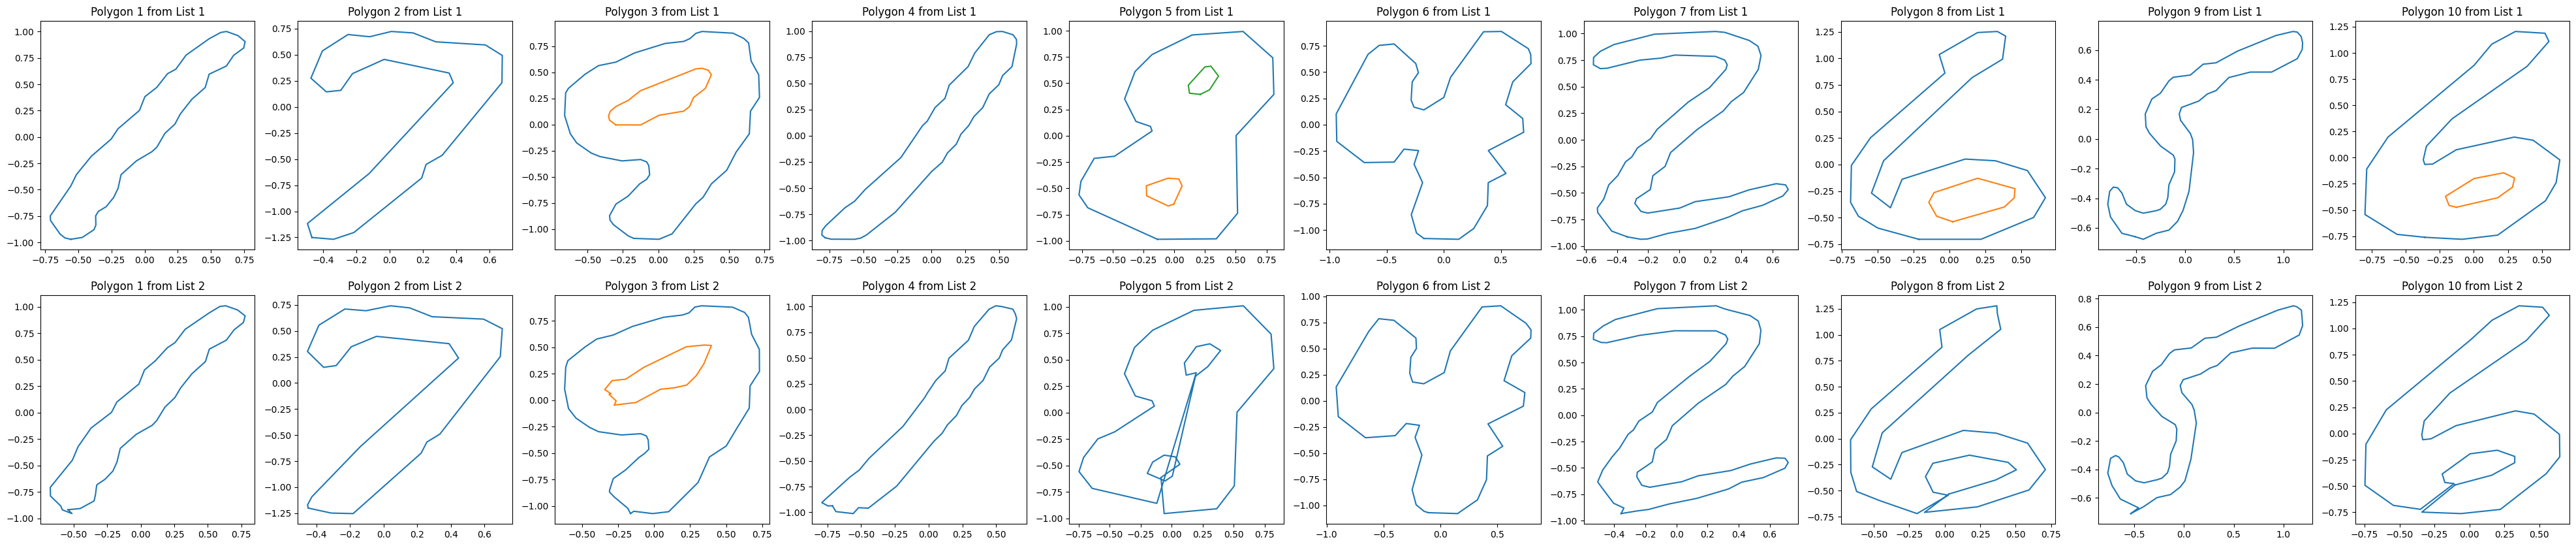

In [17]:
from utils.vector2shape import reverse_vector_polygon
import matplotlib.pyplot as plt

show_tokens = val_tokens[:10]

cae.eval()
with torch.no_grad():
    show_hidden, show_outputs, _ = cae(show_tokens)

num_samples = 10
ori_polygons = [reverse_vector_polygon(token) for token in show_tokens]
new_polygons = [reverse_vector_polygon(token) for token in show_outputs]

# Create a figure with subplots for each polygon
fig, axs = plt.subplots(2, num_samples, figsize=(5*num_samples, 10))

# Plot polygons from the first list
for i, polygon in enumerate(ori_polygons):
    axs[0, i].set_title('Polygon {} from List 1'.format(i+1))
    x, y = polygon.exterior.xy
    axs[0, i].plot(x, y)
    holes_x = [[coord[0] for coord in interior.coords] for interior in polygon.interiors]
    holes_y = [[coord[1] for coord in interior.coords] for interior in polygon.interiors]
    if holes_x:
        for hole_x, hole_y in zip(holes_x, holes_y):
            axs[0, i].plot(hole_x, hole_y)

# Plot polygons from the second list
for i, polygon in enumerate(new_polygons):
    axs[1, i].set_title('Polygon {} from List 2'.format(i+1))
    x, y = polygon.exterior.xy
    axs[1, i].plot(x, y)
    holes_x = [[coord[0] for coord in interior.coords] for interior in polygon.interiors]
    holes_y = [[coord[1] for coord in interior.coords] for interior in polygon.interiors]
    if holes_x:
        for hole_x, hole_y in zip(holes_x, holes_y):
            axs[1, i].plot(hole_x, hole_y)

# Show the plot
plt.show()

In [ ]:
import numpy as np
import utils.geom_scaler as geom_scaler

dataset_size = 1000
file = "dataset/buildings_train_v8.npz"
normalize = True

loaded = np.load(file)
geoms = loaded['fixed_size_geoms']
geom_types = loaded['building_type']
if dataset_size is not None:
    fixed_size_geoms = geoms[:dataset_size]
    geom_types = geom_types[:dataset_size]
if normalize:
    geom_scale = geom_scaler.scale(geoms)
    geoms = geom_scaler.transform(geoms, geom_scale)

polygon_dict = {}
for token, label in zip(geoms, geom_types):
    if label in polygon_dict:
        polygon_dict[label].append(token)
    else:
        polygon_dict[label] = [token]

from utils.vector2shape import reverse_vector_polygon
import matplotlib.pyplot as plt

num_samples = 10

# Create a figure with subplots for each polygon
fig, axs = plt.subplots(9, num_samples, figsize=(5*num_samples, 5*9))

for j, label in enumerate(list(polygon_dict.keys())):
    # Plot polygons from the first list
    for i, geom_vec in enumerate(polygon_dict[label][:10]):
        axs[j, i].set_title('Polygon {} from {}'.format(i+1, label))
        polygon = reverse_vector_polygon(geom_vec)
        x, y = polygon.exterior.xy
        axs[j, i].plot(x, y)

# Show the plot
plt.show()

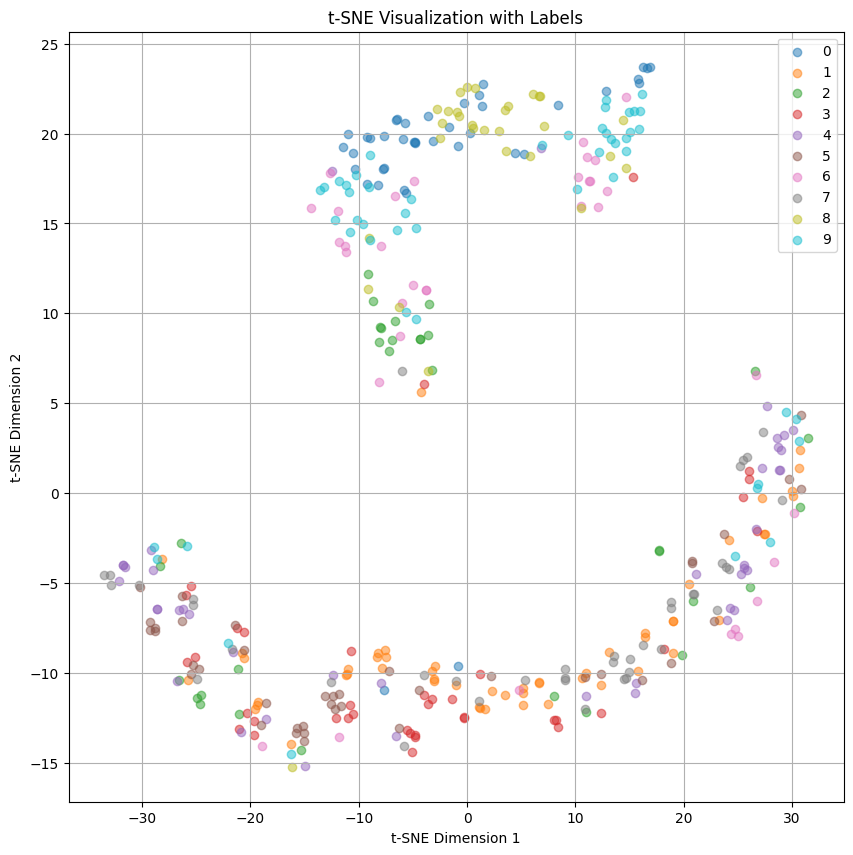

In [18]:
# show_hidden = val_tokens.view(val_tokens.size(0), -1)
show_hidden = val_hidden.view(val_hidden.size(0), -1)
show_labels = val_labels


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np


tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(show_hidden)

plt.figure(figsize=(10, 10))

# Plot each class separately
for label in np.unique(show_labels):
    indices = show_labels == label
    plt.scatter(projections[indices, 0], projections[indices, 1], label=label, alpha=0.5)

plt.title('t-SNE Visualization with Labels')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
cae.eval()
with torch.no_grad():
    train_hidden = cae(train_tokens)[0].view(train_tokens.size(0), -1)
    val_hidden = cae(val_tokens)[0].view(val_tokens.size(0), -1)


    tsne = PCA(n_components=64, random_state=0)
    train_hidden = torch.tensor(tsne.fit_transform(train_hidden), dtype=torch.float32)
    val_hidden = torch.tensor(tsne.transform(val_hidden), dtype=torch.float32)

# # Without encoding
# train_hidden = train_tokens.view(train_tokens.size(0), -1)
# val_hidden = val_tokens.view(val_tokens.size(0), -1)

train_loader = DataLoader(TensorDataset(train_hidden, train_labels), batch_size=batch_size, shuffle=True)

In [22]:
# Define the classifier
class Classifier(nn.Module):
    def __init__(self, input_size, dense_size, num_classes, dropout):
        super().__init__()
        self.dense1 = nn.Linear(input_size, dense_size)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(dense_size, num_classes)

    def forward(self, x):
        # x = self.relu(self.dense1(x))
        # x = self.dropout(x)
        # x = self.dense2(x)
        # Linear probing
        x = self.dense1(x)
        return x
    
classifier = Classifier(train_hidden.size(1), 128, 10, 0.0)

if USE_GPU:
    classifier = classifier.to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(classifier.parameters(), lr=0.004)
optimizer = optim.Adam(classifier.parameters(), lr=0.004, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001)

num_epochs = 30

def train(model, loader):
    model.eval()
    train_loss = 0.0
    correct = 0
    total = 0
    for batch_x, batch_y in loader:
        if USE_GPU:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs, dim=-1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    train_loss /= len(loader)
    train_acc = correct / total
    return train_loss, train_acc

def evaluate(model, tokens, labels):
    model.eval()
    with torch.no_grad():
        if USE_GPU:
            tokens, labels = tokens.to(device), labels.to(device)
        outputs = model(tokens)
        eval_loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, dim=-1)
        eval_acc = (predicted == labels).sum().item() / labels.size(0)
    return eval_loss, eval_acc

for epoch in range(num_epochs):
    train_loss, train_acc = train(classifier, train_loader)
    val_loss, val_acc = evaluate(classifier, val_hidden, val_labels)
    print(f"Epoch: {epoch+1}, Train Loss: {train_loss}, Train Acc {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}")


# # Test
# test_loss, test_acc = evaluate(classifier, test_loader)
# print(f"Test Loss: {test_loss}, Test Acc: {test_acc}")

Epoch: 1, Train Loss: 4.6803952407836915, Train Acc 0.1475, Val Loss: 3.4957830905914307, Val Acc: 0.375
Epoch: 2, Train Loss: 2.8493200016021727, Train Acc 0.445625, Val Loss: 2.283374547958374, Val Acc: 0.54
Epoch: 3, Train Loss: 2.004757924079895, Train Acc 0.585, Val Loss: 1.7405312061309814, Val Acc: 0.6525
Epoch: 4, Train Loss: 1.600783772468567, Train Acc 0.648125, Val Loss: 1.5315333604812622, Val Acc: 0.71
Epoch: 5, Train Loss: 1.3979014468193054, Train Acc 0.698125, Val Loss: 1.4225060939788818, Val Acc: 0.725
Epoch: 6, Train Loss: 1.2823500180244445, Train Acc 0.70875, Val Loss: 1.3614757061004639, Val Acc: 0.7275
Epoch: 7, Train Loss: 1.2042585825920105, Train Acc 0.725625, Val Loss: 1.3234381675720215, Val Acc: 0.73
Epoch: 8, Train Loss: 1.1492809176445007, Train Acc 0.73, Val Loss: 1.298685908317566, Val Acc: 0.72
Epoch: 9, Train Loss: 1.1097714400291443, Train Acc 0.74, Val Loss: 1.2748051881790161, Val Acc: 0.73
Epoch: 10, Train Loss: 1.0712814736366272, Train Acc 0.743

In [23]:
labels_array = val_labels.numpy()
length = labels_array.shape[0]
# Find unique classes and their frequencies
unique_classes, class_counts = np.unique(labels_array, return_counts=True)
fre_dict = {c: count/length for c, count in zip(unique_classes, class_counts)}
fre_dict

{0: 0.1,
 1: 0.1325,
 2: 0.08,
 3: 0.095,
 4: 0.105,
 5: 0.1,
 6: 0.0875,
 7: 0.1,
 8: 0.075,
 9: 0.125}